In [1]:
import tacoreader
import rasterio as rio
import matplotlib.pyplot as plt
import torch

from training.utils import*

/Users/hugoriffaud/Documents/Atomiser_CloudDetection/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from huggingface_hub import hf_hub_download
#dataset1 = hf_hub_download("tacofoundation/CloudSEN12", "cloudsen12-l2a.0001.part.taco", repo_type="dataset", local_dir="./data/")
#dataset1 = hf_hub_download("tacofoundation/CloudSEN12", "cloudsen12-l2a.0002.part.taco", repo_type="dataset", local_dir="./data/")
#dataset1 = hf_hub_download("tacofoundation/CloudSEN12", "cloudsen12-l2a.0003.part.taco", repo_type="dataset", local_dir="./data/")
#dataset1 = hf_hub_download("tacofoundation/CloudSEN12", "cloudsen12-l2a.0004.part.taco", repo_type="dataset", local_dir="./data/")
#dataset1 = hf_hub_download("tacofoundation/CloudSEN12", "cloudsen12-l2a.0005.part.taco", repo_type="dataset", local_dir="./data/")

In [180]:
dataset = tacoreader.load(["./data/cloudsen12-l2a.0000.part.taco","./data/cloudsen12-l2a.0001.part.taco","./data/cloudsen12-l2a.0002.part.taco","./data/cloudsen12-l2a.0003.part.taco","./data/cloudsen12-l2a.0004.part.taco","./data/cloudsen12-l2a.0005.part.taco"])
len(dataset)

50247

In [181]:
print(dataset.columns)

Index(['internal:subfile', 'tortilla:id', 'tortilla:file_format',
       'tortilla:data_split', 'tortilla:offset', 'tortilla:length', 'stac:crs',
       'stac:geotransform', 'stac:raster_shape', 'stac:time_start',
       'stac:time_end', 'stac:centroid', 'rai:ele', 'rai:cisi', 'rai:gdp',
       'rai:hdi', 'rai:gmi', 'rai:pop', 'rai:admin0', 'rai:admin1',
       'rai:admin2', 'roi_id', 'old_roi_id', 'equi_id', 'equi_zone',
       'label_type', 's2_id', 'real_proj_shape', 's2_mean_solar_azimuth_angle',
       's2_mean_solar_zenith_angle', 'thick_percentage', 'thin_percentage',
       'cloud_shadow_percentage', 'clear_percentage'],
      dtype='object')


In [182]:
#print(dataset['label_type'])
#print(dataset['tortilla:data_split'])

mask = (dataset['label_type'] == 'high')
row_ids = list(dataset[mask].index)

In [183]:
ids = dataset.loc[dataset['label_type'] == 'high', 'tortilla:id']
print(len(ids))

10847


In [184]:
print(ids)

10388    ROI_00001__20190212T142031_20190212T143214_T19FDF
10389    ROI_00001__20190304T142031_20190304T142654_T19FDF
10390    ROI_00001__20190316T141049_20190316T142437_T19FDF
10391    ROI_00001__20190525T141059_20190525T142053_T19FDF
10392    ROI_00001__20200308T141731_20200308T143551_T19FDF
                               ...                        
8927     ROI_16685__20171014T102021_20171014T102022_T35WMU
68       ROI_16701__20190811T104031_20190811T104026_T32VPK
9283     ROI_16704__20190720T054649_20190720T054813_T44ULA
9028     ROI_16705__20190903T063629_20190903T063628_T43VCG
9084     ROI_16707__20210507T155529_20210507T155523_T17RRJ
Name: tortilla:id, Length: 10847, dtype: object


In [185]:
print(row_ids)

[10388, 10389, 10390, 10391, 10392, 43500, 43501, 43502, 43503, 43504, 43505, 43506, 43507, 43508, 43509, 43510, 43511, 43512, 43513, 43514, 43515, 43516, 43517, 43518, 43519, 43520, 43521, 43522, 43523, 43524, 9293, 9294, 9295, 9296, 9297, 10393, 10394, 10395, 10396, 10397, 10398, 10399, 10400, 10401, 10402, 43525, 43526, 43527, 43528, 43529, 43530, 43531, 43532, 43533, 43534, 43535, 43536, 43537, 43538, 43539, 43540, 43541, 43542, 43543, 43544, 43545, 43546, 43547, 43548, 43549, 43550, 43551, 43552, 43553, 43554, 43555, 43556, 43557, 43558, 43559, 43560, 43561, 43562, 43563, 43564, 43565, 43566, 43567, 43568, 43569, 9298, 9299, 9300, 9301, 9302, 43570, 43571, 43572, 43573, 43574, 43575, 43576, 43577, 43578, 43579, 43580, 43581, 43582, 43583, 43584, 43585, 43586, 43587, 43588, 43589, 43590, 43591, 43592, 43593, 43594, 43595, 43596, 43597, 43598, 43599, 43600, 43601, 43602, 43603, 43604, 43605, 43606, 43607, 43608, 43609, 43610, 43611, 43612, 43613, 43614, 10403, 10404, 10405, 10406, 1

In [186]:
print(len(row_ids))

10847


In [187]:
print(dataset['tortilla:data_split'].unique())

['test' 'train' 'validation']


In [188]:
res=[]
cpt_err=0
for tmp_idx in tqdm(row_ids):
    s2_l1c = dataset.read(tmp_idx).read(0)
    s2_label = dataset.read(tmp_idx).read(1)


    # Retrieve the S2 data
    with rio.open(s2_l1c) as src, rio.open(s2_label) as dst:
        s2_l1c_data = src.read([4,3,2], window=rio.windows.Window(0, 0, 512, 512))
        s2_label_data = dst.read(window=rio.windows.Window(0, 0, 512, 512))
        if 99 in s2_label_data:
            cpt_err+=1
            continue
        res.append(tmp_idx)
row_ids=res
print(cpt_err)
print(len(row_ids))

100%|██████████| 10847/10847 [02:18<00:00, 78.21it/s]

7042
3805


In [18]:
from sklearn.model_selection import train_test_split
import numpy as np
indices = list(range(len(dataset)))  # each index is one (image, mask) pair

def get_img(sample_idx,size=512):
    sample_idx = 3
    s2_l1c = dataset.read(sample_idx).read(0)
    s2_label = dataset.read(sample_idx).read(1)

    # Retrieve the S2 data
    with rio.open(s2_l1c) as src, rio.open(s2_label) as dst:
        s2_l1c_data = src.read([4, 3, 2], window=rio.windows.Window(0, 0, size,size))
        s2_label_data = dst.read(window=rio.windows.Window(0, 0, size, size))
    
    return s2_l1c_data,s2_label_data

def get_cloud_ratio(index):
    _,mask = get_img(index)
    mask=np.array(mask)
    mask[mask==2]=1
    mask[mask==3]=0
    return mask.sum() / mask.size

def get_split_ids(indices):


    # Approximate label: low (0), medium (1), high (2) cloud coverage
    labels = []
    for i in tqdm(indices):
        r = get_cloud_ratio(i)
        if r < 0.1:
            labels.append(0)
        elif r < 0.5:
            labels.append(1)
        else:
            labels.append(2)

    train_idx, temp_idx, y_train, y_temp = train_test_split(
        indices, labels, test_size=0.2, stratify=labels, random_state=42
    )

    val_idx, test_idx, y_val, y_test = train_test_split(
        temp_idx, y_temp, test_size=0.5, stratify=y_temp, random_state=42
    )
    
    return train_idx,val_idx,test_idx

train,val,test=get_split_ids(row_ids)

100%|██████████| 6100/6100 [00:58<00:00, 104.95it/s]


In [24]:
print(len(test))

610


In [25]:
torch.save(torch.from_numpy(np.array(train)),"./data/sen12_train.pt")
torch.save(torch.from_numpy(np.array(test)),"./data/sen12_test.pt")
torch.save(torch.from_numpy(np.array(val)),"./data/sen12_validation.pt")

In [26]:
train_ids=torch.load("./data/sen12_train.pt")
validation_ids=torch.load("./data/sen12_validation.pt")
test_ids=torch.load("./data/sen12_test.pt")

In [27]:
dm = CloudSEN12DataModule(dataset=dataset,batch_size=8)

dm.setup()
train_loader = dm.train_dataloader()

[Rank 0] Train DataLoader created


2025-06-04 16:47:09,740 - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.3093333333333335].


42505
uint16


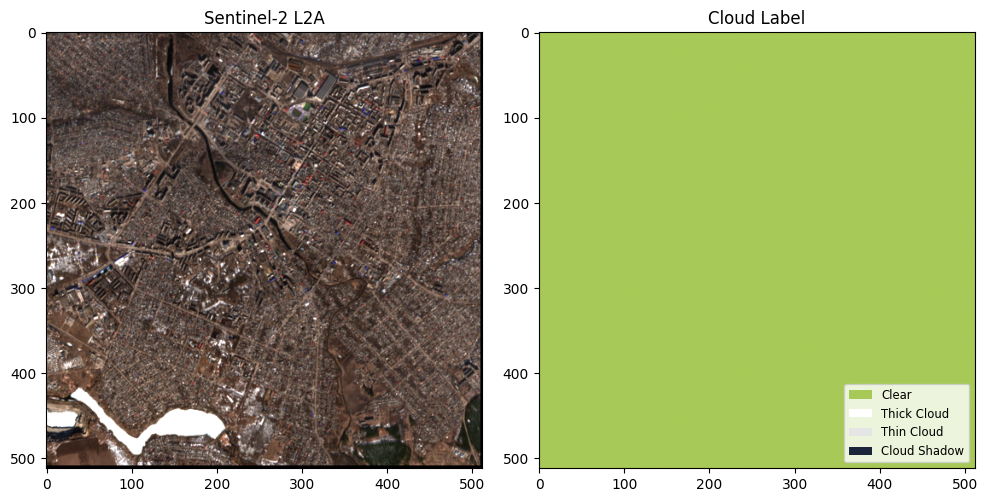

In [174]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

#%%timeit -> Remote access 827 ms ± 43.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# Read a sample
sample_idx =row_ids[int(np.random.uniform()*1000)]
print(sample_idx)
s2_l1c = dataset.read(sample_idx).read(0)
s2_label = dataset.read(sample_idx).read(1)


# Retrieve the S2 data
with rio.open(s2_l1c) as src, rio.open(s2_label) as dst:
    s2_l1c_data = src.read([4,3,2], window=rio.windows.Window(0, 0, 512, 512))
    s2_label_data = dst.read(window=rio.windows.Window(0, 0, 512, 512))
print(s2_l1c_data.dtype)



# Define custom colormap
cmap_colors ={"Clear":'#a7c957',
              "Thick Cloud":'#ffffff',
              "Thin Cloud":'#e5e5e5',
              "Cloud Shadow":'#1b263b'} 
cmap = ListedColormap([cmap_colors[idx] for idx in cmap_colors])
print(cmap)
# Plot
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(s2_l1c_data.transpose(1, 2, 0) / 3000)
ax[0].set_title("Sentinel-2 L2A")
im = ax[1].imshow(s2_label_data[0], cmap=cmap, vmin=0, vmax=3)
ax[1].set_title("Cloud Label")

# Optional: add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=cmap_colors['Clear'], label='Clear'),
    Patch(facecolor=cmap_colors['Thick Cloud'], label='Thick Cloud'),
    Patch(facecolor=cmap_colors['Thin Cloud'], label='Thin Cloud'),
    Patch(facecolor=cmap_colors['Cloud Shadow'], label='Cloud Shadow'),
]
ax[1].legend(handles=legend_elements, loc='lower right', fontsize='small')

plt.tight_layout()
plt.show()


In [175]:
import os
import torch
import numpy as np
import rasterio as rio
import einops
from tqdm import tqdm

import os
import torch
import numpy as np
import rasterio as rio
import einops
from tqdm import tqdm

def save_cloudsen12_samples_as_pt(sample_ids, dataset, destination_folder, patch_size=512):
    """
    Saves each CloudSEN12 sample as a .pt tensor of shape [H, W, 13] in uint16.
    (12 spectral bands + 1 ground truth channel).
    
    Args:
        sample_ids (List[int]): List of row/sample indices to export.
        dataset: A TacoReader-style dataset object.
        destination_folder (str): Output directory for .pt files.
        patch_size (int): Size of patch to extract (default: 512x512).
    """
    os.makedirs(destination_folder, exist_ok=True)

    for id_sample_idx in tqdm(range(sample_ids.shape[0]), desc="Saving samples"):
        sample_idx = int(sample_ids[id_sample_idx].item())
        try:
            s2_l1c = dataset.read(sample_idx).read(0)
            s2_label = dataset.read(sample_idx).read(1)

            with rio.open(s2_l1c) as src, rio.open(s2_label) as dst:
                s2_l1c_data = src.read(list(range(1, 13)), window=rio.windows.Window(0, 0, patch_size, patch_size))
                s2_label_data = dst.read(window=rio.windows.Window(0, 0, patch_size, patch_size))  # shape: [1, H, W]

            # Clip and convert to uint16
            s2_l1c_data = np.clip(s2_l1c_data, 0, 65535).astype(np.uint16)
            s2_label_data = np.clip(s2_label_data, 0, 65535).astype(np.uint16)

            # Rearrange to [H, W, C] and stack
            s2_l1c_tensor = torch.from_numpy(einops.rearrange(s2_l1c_data, "c h w -> h w c"))
            s2_label_tensor = torch.from_numpy(einops.rearrange(s2_label_data, "c h w -> h w c"))
            sample_tensor = torch.cat([s2_l1c_tensor, s2_label_tensor], dim=-1)  # [H, W, 13]

            # Save to file
            filename = f"sample_{sample_idx:05d}.pt"
            torch.save(sample_tensor, os.path.join(destination_folder, filename))

        except Exception as e:
            print(f"Error processing sample {sample_idx}: {e}")


save_cloudsen12_samples_as_pt(train_ids,dataset,"./data/cloudsen12_train/")
save_cloudsen12_samples_as_pt(validation_ids,dataset,"./data/cloudsen12_validation/")
save_cloudsen12_samples_as_pt(test_ids,dataset,"./data/cloudsen12_test/")


Saving samples: 100%|██████████| 610/610 [00:24<00:00, 25.03it/s]


In [176]:
import os
import torch
import numpy as np
from tqdm import tqdm

def compute_cloudsen12_mean_std(pt_folder, num_channels=12):
    """
    Computes per-channel mean and std over all [H, W, 13] .pt samples in a folder.
    Ignores the last (ground truth) channel.

    Args:
        pt_folder (str): Path to the folder containing .pt files.
        num_channels (int): Number of spectral channels to consider (default: 12).

    Returns:
        mean (np.ndarray): shape (12,), per-channel mean
        std (np.ndarray): shape (12,), per-channel std
    """
    channel_sum = np.zeros(num_channels, dtype=np.float64)
    channel_sq_sum = np.zeros(num_channels, dtype=np.float64)
    total_pixels = 0

    file_list = [f for f in os.listdir(pt_folder) if f.endswith(".pt")]

    for fname in tqdm(file_list, desc="Computing mean/std"):
        path = os.path.join(pt_folder, fname)
        try:
            tensor = torch.load(path)  # [H, W, 13]
            img = tensor[..., :num_channels].numpy().astype(np.float64)  # exclude GT

            img_flat = img.reshape(-1, num_channels)

            # Remove NaN/inf if needed
            valid = np.all(np.isfinite(img_flat), axis=1)
            img_flat = img_flat[valid]

            channel_sum += img_flat.sum(axis=0)
            channel_sq_sum += (img_flat ** 2).sum(axis=0)
            total_pixels += img_flat.shape[0]

        except Exception as e:
            print(f"Skipping {fname} due to error: {e}")
            continue

    if total_pixels == 0:
        raise ValueError("No valid pixels found.")

    mean = channel_sum / total_pixels
    std = np.sqrt(channel_sq_sum / total_pixels - mean**2)

    return mean, std

mean_sen,std_sen=compute_cloudsen12_mean_std("./data/cloudsen12_train/", num_channels=12)

Computing mean/std: 100%|██████████| 4880/4880 [01:16<00:00, 63.70it/s]


In [177]:
torch.save(mean_sen,"./data/cloudsen12/mean.pt")
torch.save(std_sen,"./data/cloudsen12/std.pt")

In [ ]:
import os
import torch
import numpy as np
from PIL import Image

def load_image(path):
    """Load image as float32 numpy array (GT as int if needed)."""
    return np.array(Image.open(path))

def get_common_suffixes(folder_dict):
    suffix_sets = []
    for band, folder in folder_dict.items():
        prefix = f"{band}_patch_"
        suffixes = [fname[len(prefix):] for fname in os.listdir(folder) if fname.startswith(prefix)]
        suffix_sets.append(set(suffixes))
    return sorted(set.intersection(*suffix_sets))

def process_and_save(folder_path, output_folder, suffix=''):
    """Process data and save [H, W, 5] tensors into output_folder."""
    os.makedirs(output_folder, exist_ok=True)

    folder_dict = {
        'red': os.path.join(folder_path, f'test_red{suffix}'),
        'green': os.path.join(folder_path, f'test_green{suffix}'),
        'blue': os.path.join(folder_path, f'test_blue{suffix}'),
        'nir': os.path.join(folder_path, f'test_nir{suffix}'),
        'gt': os.path.join(folder_path, f'test_gt{suffix}')
    }

    suffixes = get_common_suffixes(folder_dict)
    
    for sfx in tqdm(suffixes):
        imgs = []
        for band in ['red', 'green', 'blue', 'nir', 'gt']:
            fname = f"{band}_patch_{sfx}"
            path = os.path.join(folder_dict[band], fname)
            img = load_image(path).astype(np.float32)
            if band != 'gt':
                img = img / 255.0  # normalize spectral bands
            imgs.append(img)

        stacked = np.stack(imgs, axis=-1)  # [H, W, 5]
        tensor = torch.from_numpy(stacked)  # FloatTensor

        # Remove file extension for save name
        base_name = os.path.splitext(sfx)[0]
        save_path = os.path.join(output_folder, f"{base_name}.pt")
        torch.save(tensor, save_path)

def prepare_cloud95_data(root_dir):
    # Training data from both folders
    #process_and_save(
    #    folder_path=os.path.join(root_dir, '38-Cloud_training'),
    #    output_folder=os.path.join(root_dir, '95_train')
    #)
    #process_and_save(
    #    folder_path=os.path.join(root_dir, '95-cloud_training_only_additional_to38-cloud'),
    #    output_folder=os.path.join(root_dir, '95_train'),
    #    suffix='_additional_to38cloud'
    #)
    # Test data
    process_and_save(
        folder_path=os.path.join(root_dir, '38-Cloud_test'),
        output_folder=os.path.join(root_dir, '95_test')
    )



FileNotFoundError: [Errno 2] No such file or directory: './data/95_cloud/38-Cloud_test/test_gt'

In [139]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_sample(file_path, mean=None, std=None, normalize=False):
    """
    Load and plot a [H, W, 5] tensor from a .pt file.
    Shows RGB, NIR, and Ground Truth side by side.
    Applies normalization (if provided) and rescales for safe display.
    """
    tensor = torch.load(file_path)  # [H, W, 5]
    img = tensor[..., :4].numpy().astype(np.float32)
    gt = tensor[..., 4].numpy()

    if normalize and mean is not None and std is not None:
        img = (img - mean) / std
        print("Applied normalization")

    rgb = img[..., [0, 1, 2]]  # [H, W, 3]
    nir = img[..., 3]          # [H, W]

    # ---- 🔧 Rescale RGB for display ----
    rgb_disp = rgb.copy()
    rgb_disp -= rgb_disp.min()  # shift min to 0
    if rgb_disp.max() != 0:
        rgb_disp /= rgb_disp.max()  # scale max to 1
    # -----------------------------------

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(rgb_disp)
    plt.title("RGB (Norm + Rescaled)" if normalize else "RGB (Rescaled)")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(nir, cmap='gray')
    plt.title("NIR")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(gt, cmap='gray')
    plt.title("Ground Truth")
    plt.axis("off")

    plt.tight_layout()
    plt.show()



import os
import torch
import numpy as np
from tqdm import tqdm


import os
import torch
import numpy as np
from tqdm import tqdm

def compute_mean_std(data_dir):
    """
    Computes per-channel mean and std safely over a dataset of [H, W, 5] tensors.
    Filters out NaNs, infs, and outliers.
    """
    channel_sum = np.zeros(4, dtype=np.float64)
    channel_sq_sum = np.zeros(4, dtype=np.float64)
    total_pixels = 0

    file_list = [f for f in os.listdir(data_dir) if f.endswith(".pt")]

    for fname in tqdm(file_list, desc="Computing mean/std"):
        path = os.path.join(data_dir, fname)
        try:
            tensor = torch.load(path)  # [H, W, 5]
            img = tensor[..., :4].numpy().astype(np.float64)
            img_flat = img.reshape(-1, 4)

            # Filter: remove NaN, inf, extreme values (e.g., > 1000 just in case)
            valid = np.all(np.isfinite(img_flat), axis=1)
            valid &= (img_flat < 1000).all(axis=1)
            valid &= (img_flat > -100).all(axis=1)

            img_flat = img_flat[valid]

            channel_sum += img_flat.sum(axis=0)
            channel_sq_sum += (img_flat ** 2).sum(axis=0)
            total_pixels += img_flat.shape[0]

        except Exception as e:
            print(f"Skipping {fname} due to error: {e}")
            continue

    if total_pixels == 0:
        raise ValueError("No valid pixels found.")

    mean = channel_sum / total_pixels
    std = np.sqrt(channel_sq_sum / total_pixels - mean**2)

    return mean, std




In [ ]:
#train_dir = "./data/95_cloud/95_train/"
#mean, std = compute_mean_std(train_dir)
#print("Mean per channel (R,G,B,NIR):", mean)
#print("Std per channel (R,G,B,NIR):", std)


[33.31175119 32.91027796 35.02757681 38.70476029]


Applied normalization


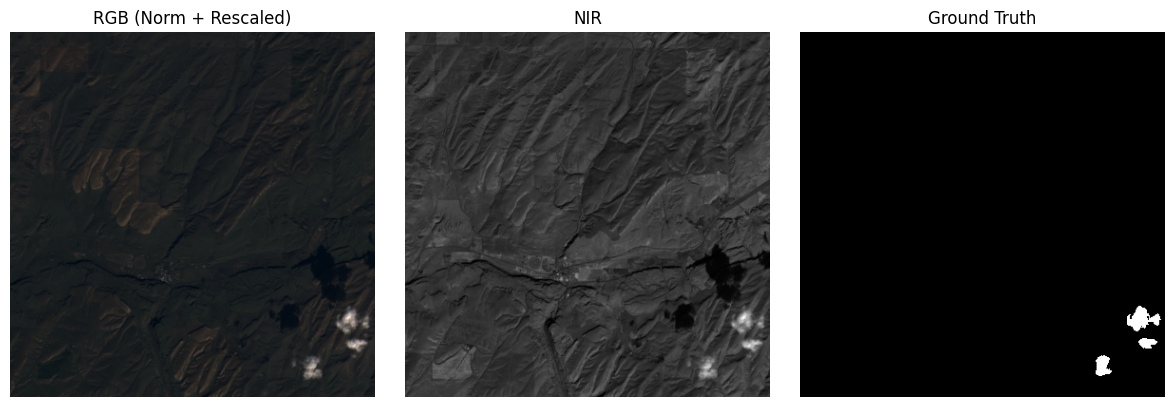

In [148]:
plot_sample("./data/95_cloud/95_train/100_5_by_16_LC08_L1TP_044028_20160220_20170224_01_T1.pt",mean=mean,std=std,normalize=True)

In [102]:

file_path = "./data/95_cloud/95_train/100_5_by_12_LC08_L1TP_006248_20160820_20170322_01_T1.pt"  # Replace with a valid filename
tensor = torch.load(file_path)  # [H, W, 5]

img = tensor[..., :4].numpy().astype(np.float64)
print("Image dtype:", tensor.dtype)
print("Per-channel min:", img.reshape(-1, 4).min(axis=0))
print("Per-channel max:", img.reshape(-1, 4).max(axis=0))
print("Per-channel mean:", img.reshape(-1, 4).mean(axis=0))

Image dtype: torch.float32
Per-channel min: [21.14509773 23.74901962 27.89411736 19.61176491]
Per-channel max: [79.47058868 75.95294189 74.23136902 69.41176605]
Per-channel mean: [45.36183582 45.70842557 49.22066546 42.11339313]


torch.Size([8, 12, 512, 512]) torch.Size([8, 512, 512])
